In [1]:
%matplotlib inline

import os, pathlib
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from IPython.display import clear_output

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    # %run "S2-decode-behav-corr.ipynb"

    print('Done')

FIGPATH = params.figPath / 'figS9-decode-behav-corr'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


---
# Part 1

functions that plot each panel.



In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [3]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

---
plot the panel

In [4]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "_monkey-corr.ipynb"
finally:
    os.chdir(NBPath)

try:
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-corr.ipynb"
finally:
    os.chdir(NBPath)
        
@utility.report
def plot_monkey_decode_corr(ax, full_list, allDFs_MCx):
    defs = monkey_defs
        
    across_corrs_monkeys = trim_across_monkey_corr(allDFs_MCx)

    pairIndex_across = []
    for I, df1 in enumerate(allDFs_MCx):
        for J, df2 in enumerate(allDFs_MCx):
            if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            pairIndex_across.append((I,J))
            
    reg_scores_across = []
    for id1, testId in pairIndex_across:
        pathPickle = root / 'monkey-pickles' / f'{allDFs_MCx[id1].session[0]}-{allDFs_MCx[testId].session[0]}_aligned.p'

        assert os.path.exists(pathPickle), 'Run figure 2 first to save the decoding data!'

        with open(pathPickle,"rb") as f:
            reg_scores_across.append(pickle.load(f))
    pop_score_across = np.array(reg_scores_across)
            
            
    corr_monkey=[]
    for i, (id1, testId) in enumerate(pairIndex_across):
        df1, df2 = allDFs_MCx[id1] , allDFs_MCx[testId]
        behav = np.array(across_corrs_monkeys[df1.session[0]][df2.session[0]])
        behav = behav[behav>params.Behav_corr_TH]
        decode = pop_score_across[i]
        corr_monkey.append((decode , np.mean(behav)))
    corr_monkey = np.array(corr_monkey)   


    #plotting
    ax.scatter(corr_monkey[:,1],corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([.15,1])
    ax.spines['left'].set_bounds([.2,1])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    
@utility.report
def plot_mouse_decode_corr(ax, AllDFs):
    defs = mouse_defs
    across_corrs_mice = trim_across_mouse_corr (AllDFs)
    
    pairIndex_across = []
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]
        pairIndex_across.append((i,[]))
        for j, df2 in enumerate(AllDFs):
            if j<i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

    M1_scores = []
    for (id1, testId) in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch_decode,
                                                      area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        
        # resizing
        _,n_trial,n_time,n_comp = AllData1.shape
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))
        AllVel2 = AllVel2.reshape((-1,n_time,3))

        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_time,n_comp))
        V = V.reshape((-1,n_time,n_comp))

        lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
        lstm_model.fit(x_train=U, y_train=AllVel1)
        lstm_model.predict(V, AllVel2)
        M1_scores.append(lstm_model.score.mean())

    M1_score_across = np.array(M1_scores)


    Str_scores = []
    for (id1, testId) in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch_decode,
                                                      area=defs.areas[1], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        
        # resizing
        _,n_trial,n_time,n_comp = AllData1.shape
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))
        AllVel2 = AllVel2.reshape((-1,n_time,3))

        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_time,n_comp))
        V = V.reshape((-1,n_time,n_comp))

        lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
        lstm_model.fit(x_train=U, y_train=AllVel1)
        lstm_model.predict(V, AllVel2)
        Str_scores.append(lstm_model.score.mean())

    Str_score_across = np.array(Str_scores)


    corr_mice=[]
    for i, (id1, testId) in enumerate(pairIndex_across):
        df1, df2 = AllDFs[id1] , AllDFs[testId]
        behav = np.array(across_corrs_mice[df1.file[0]][df2.file[0]])
        behav = behav[behav>params.Behav_corr_TH]
        M1_decode = M1_score_across[i]
        Str_decode = Str_score_across[i]
        corr_mice.append((M1_decode , np.mean(behav), Str_decode))
    corr_mice = np.array(corr_mice)

    #plotting
    ax.scatter(corr_mice[:,1],corr_mice[:,0],color=params.colors.MouseM1, label='Mice M1', zorder=1)
    ax.scatter(corr_mice[:,1],corr_mice[:,2],color=params.colors.MouseStr, label='Mice Str', zorder=1)

Executed: `get_full_monkey_data` in 12.4s
Executed: `get_full_mouse_data` in 0.6s
Executed: `plot_mouse_decode_corr` in 144.5s


/tmp/ipykernel_11937/3854961561.py:34: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch)
/tmp/ipykernel_11937/3854961561.py:48: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)
/tmp/ipykernel_11937/3854961561.py:48: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)
/tmp/ipykernel_11937/3854961561.py:48: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interva

Executed: `plot_monkey_decode_corr` in 28.7s


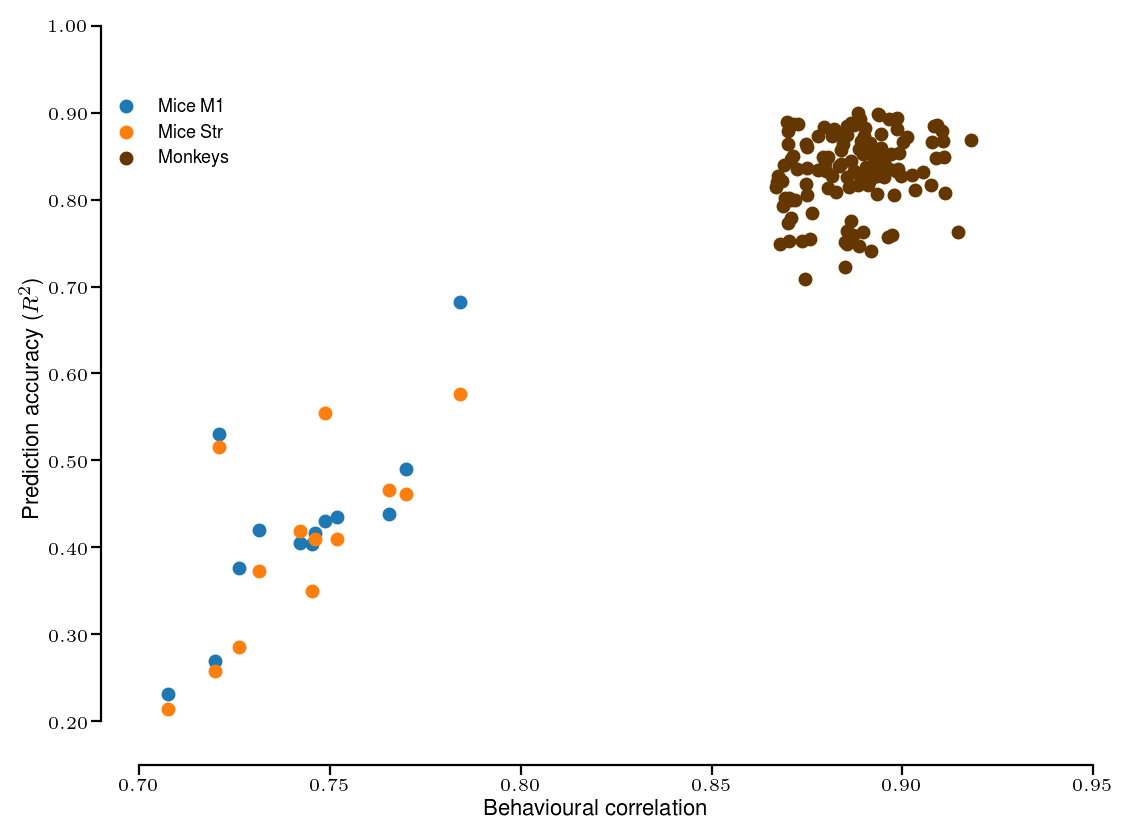

In [5]:
fig=plt.figure(dpi=100)
ax = fig.add_subplot()

full_list, allDFs_MCx = get_full_monkey_data()
allDFs_M1, _ = get_full_mouse_data()

plot_mouse_decode_corr(ax, allDFs_M1)
plot_monkey_decode_corr(ax, full_list, allDFs_MCx)

fig.savefig(FIGPATH / 'figureS9-decode-behav-corr.pdf', format='pdf', bbox_inches='tight')
